In [4]:
from seaborn import load_dataset
from sklearn.model_selection import StratifiedKFold
from junifer.storage import HDF5FeatureStorage

In [10]:
storage = HDF5FeatureStorage("./test.hdf5")
df = storage.read_df('BOLD_parccortical-Schaefer100x17')
df


,LH_VisCent_ExStr_1~LH_VisCent_ExStr_1,LH_VisCent_ExStr_2~LH_VisCent_ExStr_1,LH_VisCent_ExStr_2~LH_VisCent_ExStr_2,LH_VisCent_Striate_1~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_2,LH_VisCent_Striate_1~LH_VisCent_Striate_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_Striate_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_3,...,RH_TempPar_3~RH_DefaultA_pCunPCC_1,RH_TempPar_3~RH_DefaultA_PFCm_1,RH_TempPar_3~RH_DefaultB_PFCd_1,RH_TempPar_3~RH_DefaultB_PFCv_1,RH_TempPar_3~RH_DefaultB_PFCv_2,RH_TempPar_3~RH_DefaultC_Rsp_1,RH_TempPar_3~RH_DefaultC_PHC_1,RH_TempPar_3~RH_TempPar_1,RH_TempPar_3~RH_TempPar_2,RH_TempPar_3~RH_TempPar_3
subject,,,,,,,,,,,,,,,,,,,,,
sub-10171,1.0,0.260324,1.0,0.626423,0.110264,1.0,0.486677,0.032790,0.696503,1.0,...,0.526161,0.017163,-0.066192,0.002324,0.064164,0.459835,0.096308,0.161543,0.098310,1.0
sub-10340,1.0,0.485674,1.0,0.945421,0.394467,1.0,0.908395,0.518282,0.790870,1.0,...,0.607221,-0.402949,-0.057935,-0.018655,0.025229,0.504591,0.420506,0.377274,0.851766,1.0


In [6]:
storage.list_features()

{'c3ae7d8f77986f34a8fa4554bde2fe34': {'datagrabber': {'class': 'PatternDataladDataGrabber',
   'patterns': {'BOLD': {'pattern': '{subject}/func/{subject}_task-rest_bold.nii.gz',
     'space': 'MNI152NLin6Asym'}},
   'replacements': ['subject'],
   'confounds_format': None,
   'types': ['BOLD'],
   'uri': 'https://github.com/OpenNeuroDatasets/ds000030.git',
   'datalad_dirty': False,
   'datalad_commit_id': '4070b6eea231517bfeff42527a46d9d166ac4e13',
   'datalad_id': '865f2374-8a15-11e8-bc84-0242ac120022'},
  'dependencies': {'scikit-learn': '1.3.2', 'nilearn': '0.10.2'},
  'datareader': {'class': 'DefaultDataReader'},
  'type': 'BOLD',
  'marker': {'class': 'FunctionalConnectivityParcels',
   'parcellation': ['Schaefer100x17'],
   'agg_method': 'mean',
   'agg_method_params': None,
   'cor_method': 'correlation',
   'cor_method_params': {'empirical': True},
   'masks': None,
   'name': 'parccortical-Schaefer100x17'},
  '_element_keys': ['subject'],
  'name': 'BOLD_parccortical-Schaefer

In [22]:
df.shape

(1, 100)

In [17]:
df.iloc[0,:]

LH_VisCent_ExStr_1~LH_VisCent_ExStr_1      1.000000
LH_VisCent_ExStr_2~LH_VisCent_ExStr_1      0.260324
LH_VisCent_ExStr_2~LH_VisCent_ExStr_2      1.000000
LH_VisCent_Striate_1~LH_VisCent_ExStr_1    0.626423
LH_VisCent_Striate_1~LH_VisCent_ExStr_2    0.110264
                                             ...   
RH_TempPar_3~RH_DefaultC_Rsp_1             0.459835
RH_TempPar_3~RH_DefaultC_PHC_1             0.096308
RH_TempPar_3~RH_TempPar_1                  0.161543
RH_TempPar_3~RH_TempPar_2                  0.098310
RH_TempPar_3~RH_TempPar_3                  1.000000
Name: (sub-10171,), Length: 5050, dtype: float32

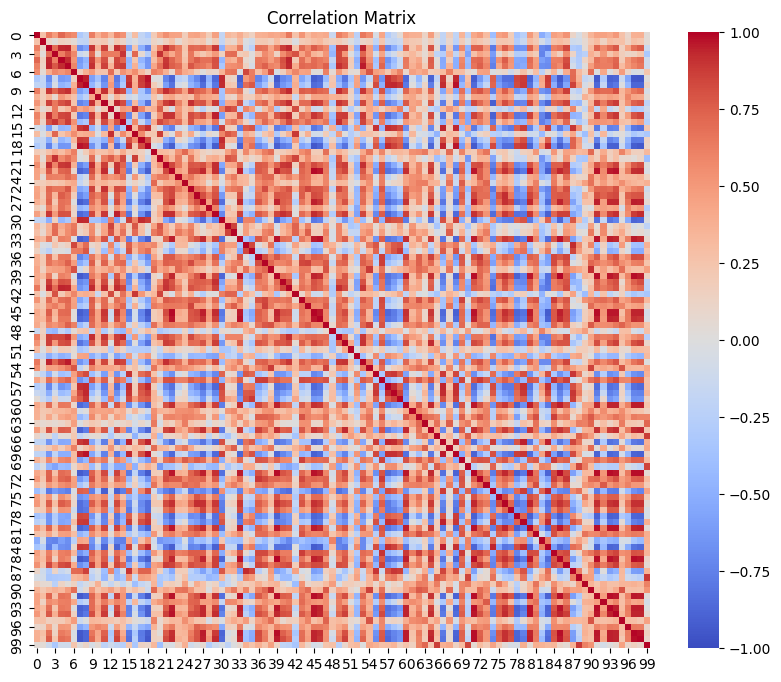

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(lower_tri_array):
    # Determine the size of the matrix
    n = int((np.sqrt(1 + 8 * len(lower_tri_array)) - 1) / 2)
    
    # Initialize the correlation matrix
    corr_matrix = np.zeros((n, n))
    
    # Fill the lower triangular part and the diagonal
    tri_indices = np.tril_indices(n)
    corr_matrix[tri_indices] = lower_tri_array
    
    # Reflect the lower triangular part to the upper triangular part
    corr_matrix = corr_matrix + corr_matrix.T - np.diag(corr_matrix.diagonal())
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title('Correlation Matrix')
    plt.show()

# Example usage  # This represents a 3x3 correlation matrix
plot_correlation_matrix(df.iloc[0,:]+df.iloc[1,:])
